## EDA: Calculating Distances between Census Tracts

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

%pylab inline

#suppress warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [6]:
#set working directory
os.chdir('/projects/mpi/shared/Data')
os.getcwd()

'/projects/mpi/shared/Data'

In [3]:
#import census tract file
shapes = gpd.read_file('all_cts.shp')

#import trip files
nyc = pd.read_csv('ny_ct.csv')
chic = pd.read_csv('chic_ct.csv')
sf = pd.read_csv('sf_ct.csv')
la = pd.read_csv('la_ct.csv')

In [4]:
#get centroid of each census tract
shapes['points'] = shapes['geometry'].centroid

#just keep the columns needed
points = shapes[['GEOID','points']]

#extract the lat-lon points from points column
points['lon'] = points['points'].apply(lambda p: p.x)
points['lat'] = points['points'].apply(lambda p: p.y)

#set geoid column as int before joining to OD data
points['GEOID'] = points['GEOID'].astype(int)

In [5]:
#join lat-lon to OD file
df_list = [nyc,chic,sf,la]

new_df_list = []

for df in df_list:
    df = pd.merge(left=df,right=points,left_on='origin_ct',right_on='GEOID')
    df.drop(['GEOID','points'],axis=1,inplace=True)
    df.rename({'lon':'origin_lon','lat':'origin_lat'},axis=1,inplace=True)

    df = pd.merge(left=df,right=points,left_on='dest_ct',right_on='GEOID')
    df.drop(['GEOID','points'],axis=1,inplace=True)
    df.rename({'lon':'dest_lon','lat':'dest_lat'},axis=1,inplace=True)

    #df['dist'] = haversine_distance(df['origin_lon'],df['origin_lat'],df['dest_lon'],df['dest_lat'])

    new_df_list.append(df)

nyc = new_df_list[0]
chic = new_df_list[1]
sf = new_df_list[2]
la = new_df_list[3]

In [6]:
#function for measuring distance between origin and destination
def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [7]:
#add distance column for each city
nyc['dist'] = haversine_distance(nyc['origin_lon'],nyc['origin_lat'],nyc['dest_lon'],nyc['dest_lat'])
chic['dist'] = haversine_distance(chic['origin_lon'],chic['origin_lat'],chic['dest_lon'],chic['dest_lat'])
la['dist'] = haversine_distance(la['origin_lon'],la['origin_lat'],la['dest_lon'],la['dest_lat'])
sf['dist'] = haversine_distance(sf['origin_lon'],sf['origin_lat'],sf['dest_lon'],sf['dest_lat'])

## Histogram of Trip Distance

[]

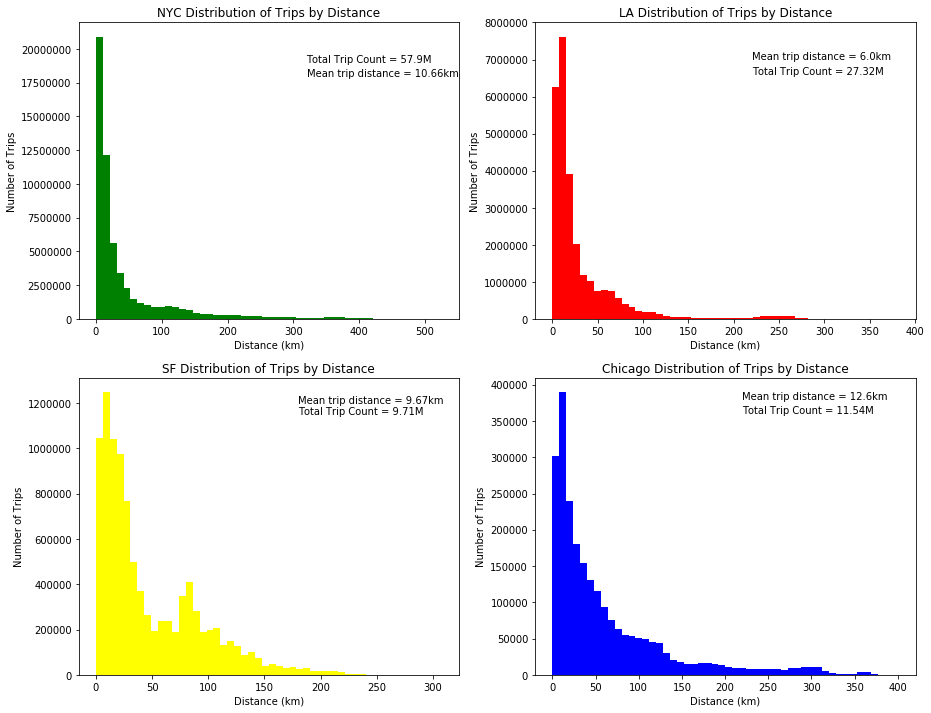

In [8]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)

ax1.set_ylabel("Number of Trips")
ax1.set_xlabel("Distance (km)")
ax1.set_title("NYC Distribution of Trips by Distance")
ax1.hist(nyc['dist'],bins=50,weights=nyc['od_counts'],color='green')
ax1.text(x=320,y=18000000,s="Mean trip distance = {}km".format(round((nyc['dist'].sum()) / (nyc['od_counts'].sum()),2)))
ax1.text(x=320,y=19000000,s="Total Trip Count = {}M".format(round(nyc['od_counts'].sum() / 1000000,2)))
ax1.get_yaxis().get_major_formatter().set_scientific(False)

ax2 = fig.add_subplot(222)

ax2.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (km)")
ax2.set_title("LA Distribution of Trips by Distance")
ax2.hist(la['dist'],bins=50,weights=la['od_counts'],color='red')
ax2.text(x=220,y=7000000,s="Mean trip distance = {}km".format(round((la['dist'].sum()) / (la['od_counts'].sum()),2)))
ax2.text(x=220,y=6600000,s="Total Trip Count = {}M".format(round(la['od_counts'].sum() / 1000000,2)))

ax3 = fig.add_subplot(223)

ax3.set_ylabel("Number of Trips")
ax3.set_xlabel("Distance (km)")
ax3.set_title("SF Distribution of Trips by Distance")
ax3.hist(sf['dist'],bins=50,weights=sf['od_counts'],color='yellow')
ax3.text(x=180,y=1200000,s="Mean trip distance = {}km".format(round((sf['dist'].sum()) / (sf['od_counts'].sum()),2)))
ax3.text(x=180,y=1150000,s="Total Trip Count = {}M".format(round(sf['od_counts'].sum() / 1000000,2)))

ax4 = fig.add_subplot(224)

ax4.set_ylabel("Number of Trips")
ax4.set_xlabel("Distance (km)")
ax4.set_title("Chicago Distribution of Trips by Distance")
ax4.hist(chic['dist'],bins=50,color='blue')
ax4.text(x=220,y=380000,s="Mean trip distance = {}km".format(round((chic['dist'].sum()) / (chic['od_counts'].sum()),2)))
ax4.text(x=220,y=360000,s="Total Trip Count = {}M".format(round(chic['od_counts'].sum() / 1000000,2)))

plt.plot()

## Layered Histogram for All Cities

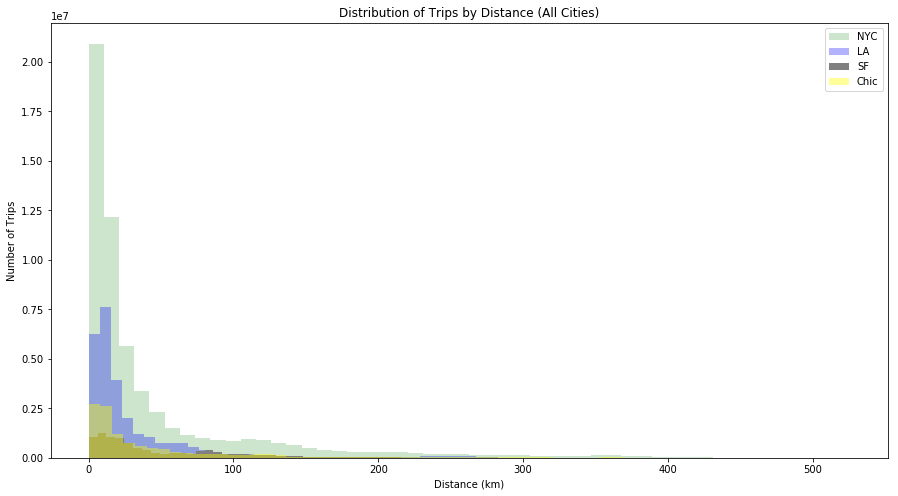

In [9]:
#generate figure
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)

ax1.set_ylabel("Number of Trips")
ax1.set_xlabel("Distance (km)")
ax1.set_title("Distribution of Trips by Distance (All Cities)")
ax1.hist(nyc['dist'],bins=50,weights=nyc['od_counts'],color='green',alpha=0.2,label='NYC')
ax1.hist(la['dist'],bins=50,weights=la['od_counts'],color='blue',alpha=0.3,label='LA')
ax1.hist(sf['dist'],bins=50,weights=sf['od_counts'],color='grey',alpha=1,label='SF')
ax1.hist(chic['dist'],bins=50,weights=chic['od_counts'],color='yellow',alpha=0.4,label='Chic')

plt.legend()
plt.show()

## Box and Whisker Plots of Distance

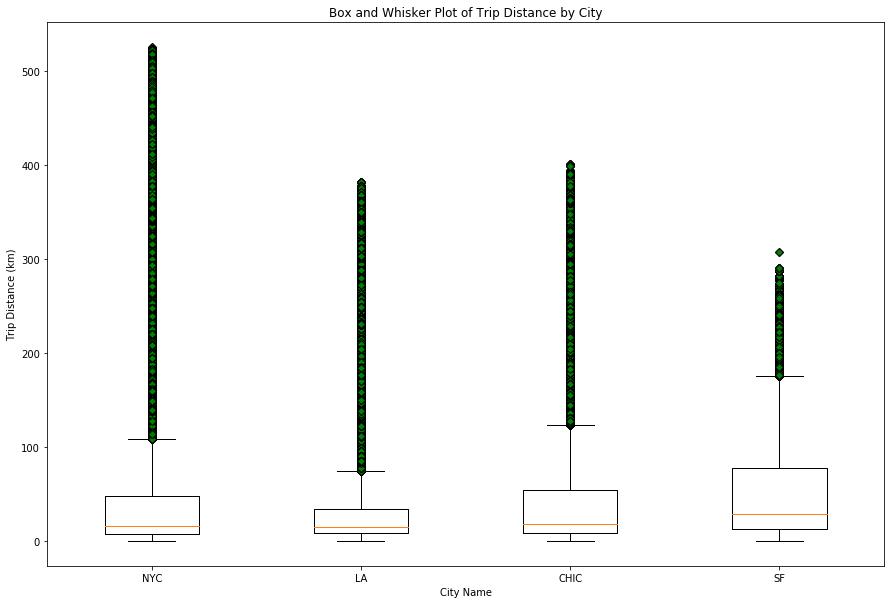

In [10]:
#generate list of values weighted based on number of trips
nyc_weighted = []
for index, row in nyc.iterrows():
    weighted_row = [row['dist']]*row['od_counts']
    nyc_weighted += weighted_row

la_weighted = []
for index, row in la.iterrows():
    weighted_row = [row['dist']]*row['od_counts']
    la_weighted += weighted_row

chic_weighted = []
for index, row in chic.iterrows():
    weighted_row = [row['dist']]*row['od_counts']
    chic_weighted += weighted_row
    
sf_weighted = []
for index, row in sf.iterrows():
    weighted_row = [row['dist']]*row['od_counts']
    sf_weighted += weighted_row
    
#concat data
data = [nyc_weighted,la_weighted,chic_weighted,sf_weighted]
green_diamond = dict(markerfacecolor='g', marker='D',)

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
ax1.boxplot(data,showfliers=True,flierprops=green_diamond)
ax1.set_xlabel("City Name")
ax1.set_ylabel("Trip Distance (km)")

plt.title("Box and Whisker Plot of Trip Distance by City")
plt.xticks([1,2,3,4], ['NYC','LA','CHIC','SF'])
plt.show()

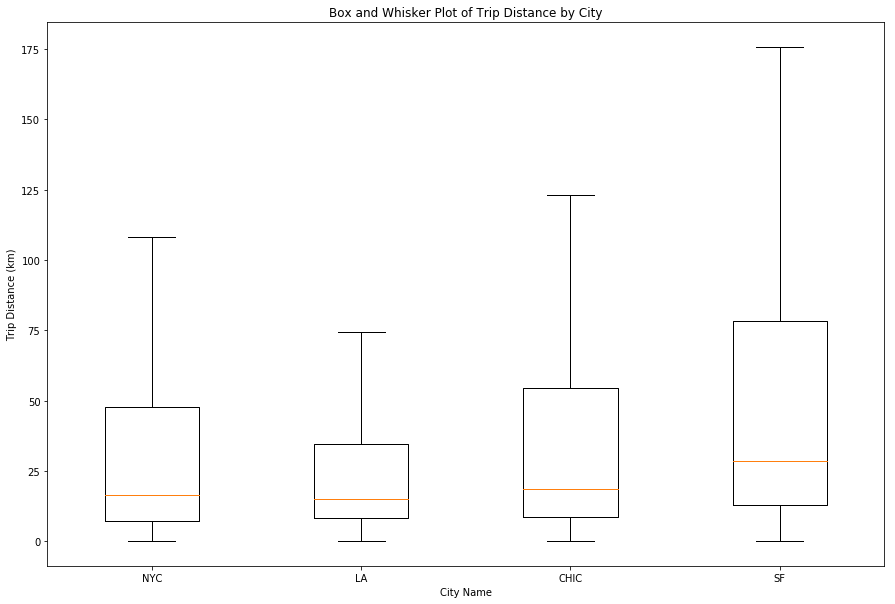

In [11]:
#generate list of values weighted based on number of trips
nyc_weighted = []
for index, row in nyc.iterrows():
    weighted_row = [row['dist']] * row['od_counts']
    nyc_weighted += weighted_row

la_weighted = []
for index, row in la.iterrows():
    weighted_row = [row['dist']]*row['od_counts']
    la_weighted += weighted_row

chic_weighted = []
for index, row in chic.iterrows():
    weighted_row = [row['dist']]*row['od_counts']
    chic_weighted += weighted_row
    
sf_weighted = []
for index, row in sf.iterrows():
    weighted_row = [row['dist']]*row['od_counts']
    sf_weighted += weighted_row
    
#concat data
data = [nyc_weighted,la_weighted,chic_weighted,sf_weighted]
green_diamond = dict(markerfacecolor='g', marker='D',)

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
ax1.boxplot(data,showfliers=False)
ax1.set_xlabel("City Name")
ax1.set_ylabel("Trip Distance (km)")

plt.title("Box and Whisker Plot of Trip Distance by City")
plt.xticks([1,2,3,4], ['NYC','LA','CHIC','SF'])
plt.show()

## Average Distance by Decile and City

In [12]:
#create deciles dataframes from 
df_list = [nyc_weighted,la_weighted,sf_weighted,chic_weighted]
decile_list = []
for i in df_list:
    df = pd.DataFrame(i)
    df['decile'] = pd.qcut(df[0],10,labels=False)
    decile_df = pd.DataFrame(round(df.groupby('decile')[0].median(),2))
    decile_df.reset_index(inplace=True)
    decile_list.append(decile_df)

nyc_decile = decile_list[0]
la_decile = decile_list[1]
sf_decile = decile_list[2]
chic_decile = decile_list[3]

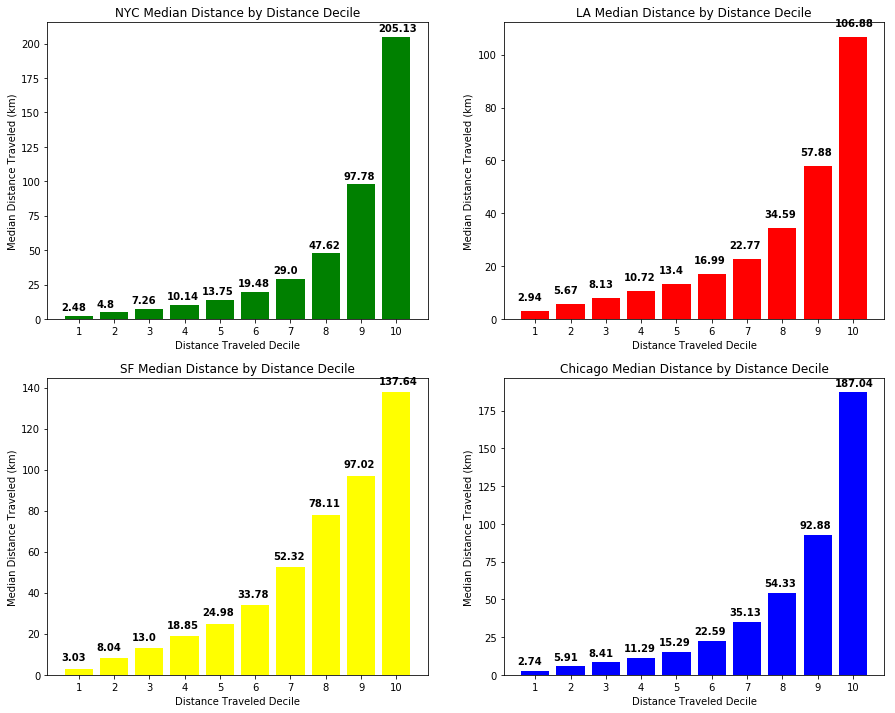

In [13]:
#create figures
fig = plt.figure(figsize=(15,12))

ax1 = fig.add_subplot(221)
ax1.bar(x=nyc_decile['decile'],height=nyc_decile[0],color='green')
ax1.set_xlabel("Distance Traveled Decile")
ax1.set_ylabel("Median Distance Traveled (km)")
ax1.set_title("NYC Median Distance by Distance Decile")
ax1.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax1.set_xticklabels([1,2,3,4,5,6,7,8,9,10])

for i, v in enumerate(list(nyc_decile[0])):
    ax1.text(i - 0.5,v + 4, str(v), fontweight='bold')

ax2 = fig.add_subplot(222)
ax2.bar(x=la_decile['decile'],height=la_decile[0],color='red')
ax2.set_xlabel("Distance Traveled Decile")
ax2.set_ylabel("Median Distance Traveled (km)")
ax2.set_title("LA Median Distance by Distance Decile")
ax2.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax2.set_xticklabels([1,2,3,4,5,6,7,8,9,10])

for i, v in enumerate(list(la_decile[0])):
    ax2.text(i - 0.5,v + 4, str(v), fontweight='bold')

ax3 = fig.add_subplot(223)
ax3.bar(x=sf_decile['decile'],height=sf_decile[0],color='yellow')
ax3.set_xlabel("Distance Traveled Decile")
ax3.set_ylabel("Median Distance Traveled (km)")
ax3.set_title("SF Median Distance by Distance Decile")
ax3.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax3.set_xticklabels([1,2,3,4,5,6,7,8,9,10])

for i, v in enumerate(list(sf_decile[0])):
    ax3.text(i - 0.5,v + 4, str(v), fontweight='bold')

ax4 = fig.add_subplot(224)
ax4.bar(x=chic_decile['decile'],height=chic_decile[0],color='blue')
ax4.set_xlabel("Distance Traveled Decile")
ax4.set_ylabel("Median Distance Traveled (km)")
ax4.set_title("Chicago Median Distance by Distance Decile")
ax4.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax4.set_xticklabels([1,2,3,4,5,6,7,8,9,10])

for i, v in enumerate(list(chic_decile[0])):
    ax4.text(i - 0.5,v + 4, str(v), fontweight='bold')

plt.show()

## Counts of Trips by Time

In [14]:
def time_num(row):
    """function to convert time period to a numeric value"""
    if row['time_period']=='6:00 - 6:30':
        return 1
    elif row['time_period']=='6:30 - 7:00':
        return 2
    elif row['time_period']=='7:00 - 7:30':
        return 3
    elif row['time_period']=='7:30 - 8:00':
        return 4
    elif row['time_period']=='8:00 - 8:30':
        return 5
    elif row['time_period']=='8:30 - 9:00':
        return 6
    elif row['time_period']=='9:00 - 9:30':
        return 7
    elif row['time_period']=='9:30 - 10:00':
        return 8
    else:
        return 9

In [15]:
nyc['time_period2'] = nyc.apply(lambda x: time_num(x),axis=1)
la['time_period2'] = la.apply(lambda x: time_num(x),axis=1)
chic['time_period2'] = chic.apply(lambda x: time_num(x),axis=1)
sf['time_period2'] = sf.apply(lambda x: time_num(x),axis=1)

In [16]:
#generate data frames for plotting by time
df_list = [nyc,la,sf,chic]
time_counts = []
for i in df_list:
    df = pd.DataFrame(i.groupby('time_period2')['od_counts'].sum())
    df.reset_index(inplace=True)
    time_counts.append(df)

nyc_time = time_counts[0]
la_time = time_counts[1]
sf_time = time_counts[2]
chic_time = time_counts[3]

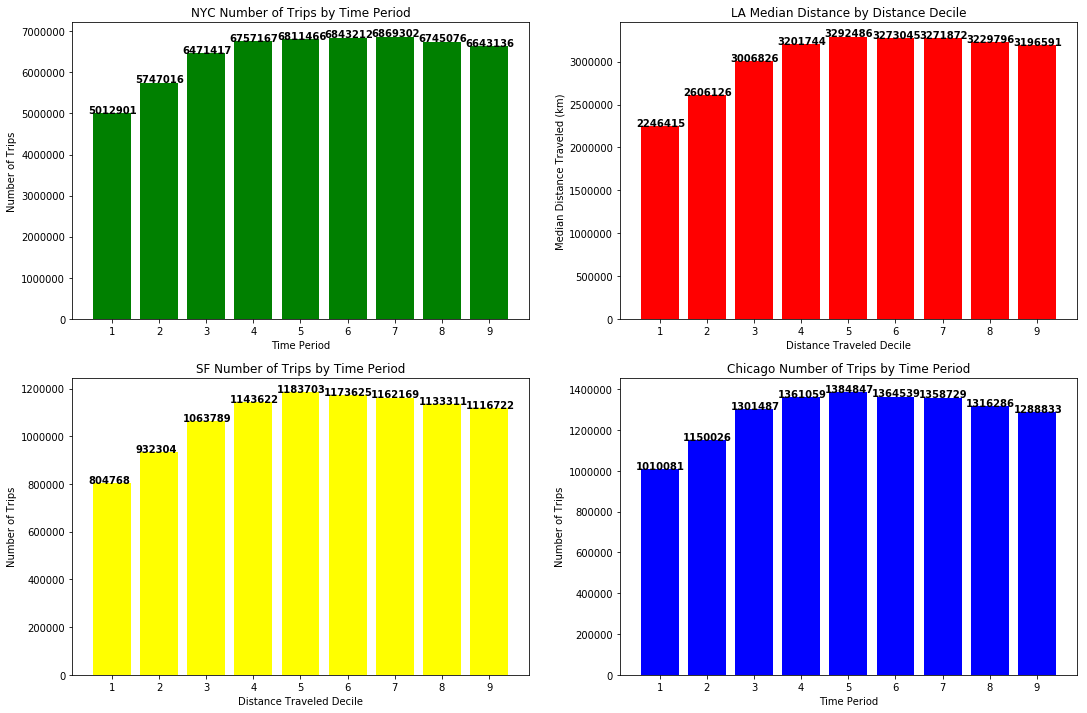

In [17]:
#create figures
fig = plt.figure(figsize=(18,12))

ax1 = fig.add_subplot(221)
ax1.bar(x=nyc_time['time_period2'],height=nyc_time['od_counts'],color='green')
ax1.set_xlabel("Time Period")
ax1.set_ylabel("Number of Trips")
ax1.set_title("NYC Number of Trips by Time Period")
ax1.set_xticks([1,2,3,4,5,6,7,8,9])
ax1.set_xticklabels([1,2,3,4,5,6,7,8,9])

for i, v in enumerate(list(nyc_time['od_counts'])):
    ax1.text(i+0.5,v + 4, str(v), fontweight='bold')

ax2 = fig.add_subplot(222)
ax2.bar(x=la_time['time_period2'],height=la_time['od_counts'],color='red')
ax2.set_xlabel("Distance Traveled Decile")
ax2.set_ylabel("Median Distance Traveled (km)")
ax2.set_title("LA Median Distance by Distance Decile")
ax2.set_xticks([1,2,3,4,5,6,7,8,9])
ax2.set_xticklabels([1,2,3,4,5,6,7,8,9])

for i, v in enumerate(list(la_time['od_counts'])):
    ax2.text(i+0.5,v + 4, str(v), fontweight='bold')

ax3 = fig.add_subplot(223)
ax3.bar(x=sf_time['time_period2'],height=sf_time['od_counts'],color='yellow')
ax3.set_xlabel("Distance Traveled Decile")
ax3.set_ylabel("Number of Trips")
ax3.set_title("SF Number of Trips by Time Period")
ax3.set_xticks([1,2,3,4,5,6,7,8,9])
ax3.set_xticklabels([1,2,3,4,5,6,7,8,9])

for i, v in enumerate(list(sf_time['od_counts'])):
    ax3.text(i+0.5,v+4, str(v), fontweight='bold')

ax4 = fig.add_subplot(224)
ax4.bar(x=chic_time['time_period2'],height=chic_time['od_counts'],color='blue')
ax4.set_xlabel("Time Period")
ax4.set_ylabel("Number of Trips")
ax4.set_title("Chicago Number of Trips by Time Period")
ax4.set_xticks([1,2,3,4,5,6,7,8,9])
ax4.set_xticklabels([1,2,3,4,5,6,7,8,9])

for i, v in enumerate(list(chic_time['od_counts'])):
    ax4.text(i+0.5,v + 6, str(v), fontweight='bold')

plt.show()

## Distribution of Trip Volume By Start Location

In [18]:
nyc_start = pd.DataFrame(nyc.groupby('origin_ct')['od_counts'].sum())

In [19]:
print("Average Number of Trips Started per Day {}".format(nyc_start['od_counts'].mean() / 120))
print(nyc_start['od_counts'].min())
print(nyc_start['od_counts'].max())
print(nyc_start['od_counts'].median())

Average Number of Trips Started per Day 56.222998718247496
4
84047
4724.0


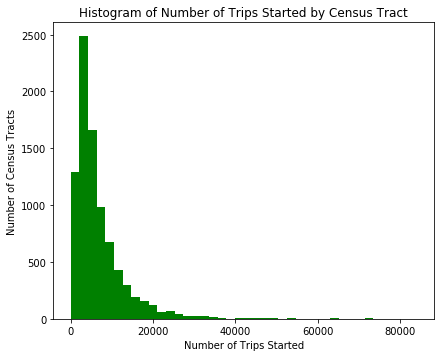

In [20]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)

ax1.set_ylabel("Number of Census Tracts")
ax1.set_xlabel("Number of Trips Started")
ax1.set_title("Histogram of Number of Trips Started by Census Tract")
ax1.hist(nyc_start['od_counts'],bins=40,color='green')
plt.show()

### Filter Records based on Lat-Lon Bounding Boxes and Speed

In [28]:
#defined based on bounding box
nyc_lon_min = -74.451599
nyc_lon_max = -72.784424
nyc_lat_min = 40.423951
nyc_lat_max = 41.391234

In [37]:
#nyc cleaned dataframe
nyc_clean = nyc[(nyc['origin_lon']>nyc_lon_min)&(nyc['origin_lon']<nyc_lon_max)&(nyc['dest_lon']>nyc_lon_min) \
               &(nyc['dest_lon']<nyc_lon_max)&(nyc['origin_lat']>nyc_lat_min)&(nyc['origin_lat']<nyc_lat_max) \
                &(nyc['dest_lat']>nyc_lat_min)&(nyc['dest_lat']<nyc_lat_max)]

In [39]:
#define chicago bounding box parameters
chic_lon_min = -88.393250
chic_lon_max = -86.800232
chic_lat_min = 41.403596
chic_lat_max = 42.463993

In [40]:
#filter chicago dataframe
chic_clean = chic[(chic['origin_lon']>chic_lon_min)&(chic['origin_lon']<chic_lon_max)&(chic['dest_lon']>chic_lon_min) \
               &(chic['dest_lon']<chic_lon_max)&(chic['origin_lat']>chic_lat_min)&(chic['origin_lat']<chic_lat_max) \
                &(chic['dest_lat']>chic_lat_min)&(chic['dest_lat']<chic_lat_max)]

In [43]:
#define SF bounding box parameters
sf_lon_min = -122.695313
sf_lon_max = -121.679077
sf_lat_min = 37.197518
sf_lat_max = 37.981010

In [44]:
#filter SF data frame
sf_clean = sf[(sf['origin_lon']>sf_lon_min)&(sf['origin_lon']<sf_lon_max)&(sf['dest_lon']>sf_lon_min) \
               &(sf['dest_lon']<sf_lon_max)&(sf['origin_lat']>sf_lat_min)&(sf['origin_lat']<sf_lat_max) \
                &(sf['dest_lat']>sf_lat_min)&(sf['dest_lat']<sf_lat_max)]

In [45]:
#define LA bounding box parameters
la_lon_min = -118.795166
la_lon_max = -116.900024
la_lat_min = 33.415395
la_lat_max = 34.440894

In [46]:
#filter LA dataframe
la_clean = la[(la['origin_lon']>la_lon_min)&(la['origin_lon']<la_lon_max)&(la['dest_lon']>la_lon_min) \
               &(la['dest_lon']<la_lon_max)&(la['origin_lat']>la_lat_min)&(la['origin_lat']<la_lat_max) \
                &(la['dest_lat']>la_lat_min)&(la['dest_lat']<la_lat_max)]

In [53]:
#filter each dataframe based on speed
nyc_clean['dist_per_hr'] = nyc_clean['dist'] * 2
sf_clean['dist_per_hr'] = sf_clean['dist'] * 2
la_clean['dist_per_hr'] = la_clean['dist'] * 2
chic_clean['dist_per_hr'] = chic_clean['dist'] * 2

nyc_clean = nyc_clean[nyc_clean['dist_per_hr'] < 120]
sf_clean = sf_clean[sf_clean['dist_per_hr'] < 120]
la_clean = la_clean[la_clean['dist_per_hr'] < 120]
chic_clean = chic_clean[chic_clean['dist_per_hr'] < 120]

In [54]:
#export dataframes as cleaned csv files
sf_clean.to_csv('sf_clean.csv')
nyc_clean.to_csv('nyc_clean.csv')
la_clean.to_csv('la_clean.csv')
chic_clean.to_csv('chic_clean.csv')

## EDA with Cleaned Data

In [7]:
sf_clean = pd.read_csv('sf_clean.csv')
nyc_clean = pd.read_csv('nyc_clean.csv')
la_clean = pd.read_csv('la_clean.csv')
chic_clean = pd.read_csv('chic_clean.csv')

Text(0.5, 1.0, 'Median Distance Traveled by City')

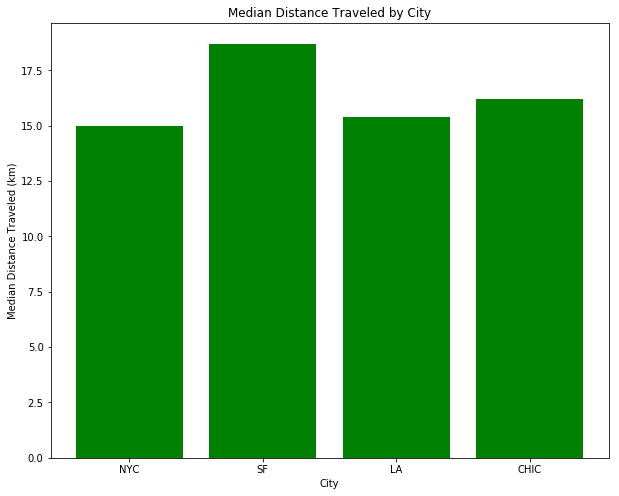

In [14]:
#median and average distance 
median_list = [nyc_clean['dist'].median(),sf_clean['dist'].median(),la_clean['dist'].median(),
               chic_clean['dist'].median()]

city_list = ['NYC','SF','LA','CHIC']

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

ax1.bar(x=city_list,height=median_list,color='green')
ax1.set_xlabel("City")
ax1.set_ylabel("Median Distance Traveled (km)")
ax1.set_title("Median Distance Traveled by City")

[]

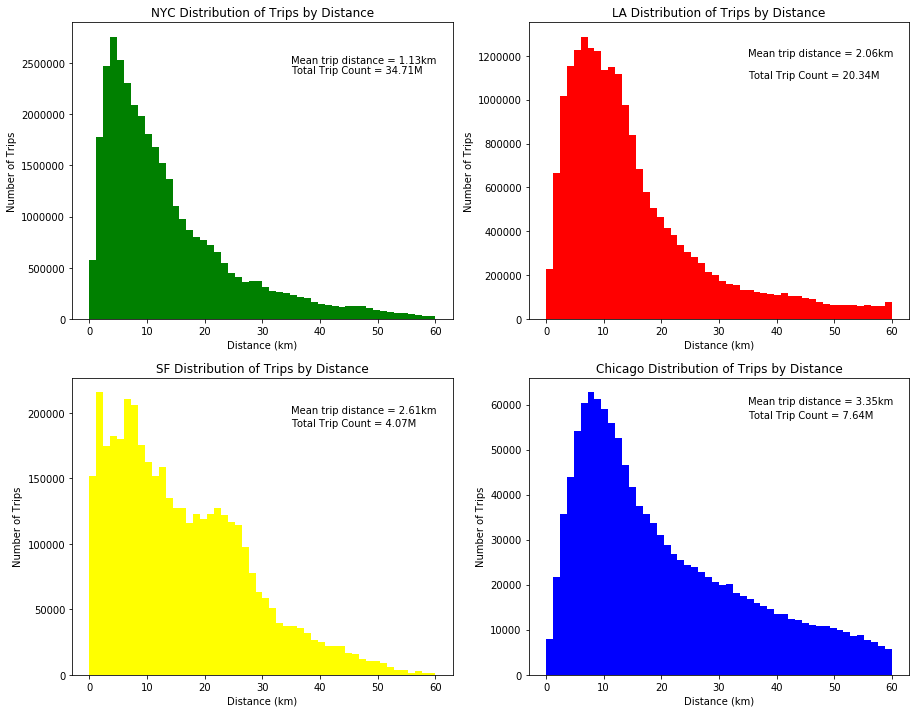

In [8]:
#distribution plots of distance travelled 
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)

ax1.set_ylabel("Number of Trips")
ax1.set_xlabel("Distance (km)")
ax1.set_title("NYC Distribution of Trips by Distance")
ax1.hist(nyc_clean['dist'],bins=50,weights=nyc_clean['od_counts'],color='green')
ax1.text(x=35,y=2500000,s="Mean trip distance = {}km".format(round((nyc_clean['dist'].sum()) / (nyc_clean['od_counts'].sum()),2)))
ax1.text(x=35,y=2400000,s="Total Trip Count = {}M".format(round(nyc_clean['od_counts'].sum() / 1000000,2)))
ax1.get_yaxis().get_major_formatter().set_scientific(False)

ax2 = fig.add_subplot(222)

ax2.set_ylabel("Number of Trips")
ax2.set_xlabel("Distance (km)")
ax2.set_title("LA Distribution of Trips by Distance")
ax2.hist(la_clean['dist'],bins=50,weights=la_clean['od_counts'],color='red')
ax2.text(x=35,y=1200000,s="Mean trip distance = {}km".format(round((la_clean['dist'].sum()) / (la_clean['od_counts'].sum()),2)))
ax2.text(x=35,y=1100000,s="Total Trip Count = {}M".format(round(la_clean['od_counts'].sum() / 1000000,2)))

ax3 = fig.add_subplot(223)

ax3.set_ylabel("Number of Trips")
ax3.set_xlabel("Distance (km)")
ax3.set_title("SF Distribution of Trips by Distance")
ax3.hist(sf_clean['dist'],bins=50,weights=sf_clean['od_counts'],color='yellow')
ax3.text(x=35,y=200000,s="Mean trip distance = {}km".format(round((sf_clean['dist'].sum()) / (sf_clean['od_counts'].sum()),2)))
ax3.text(x=35,y=190000,s="Total Trip Count = {}M".format(round(sf_clean['od_counts'].sum() / 1000000,2)))

ax4 = fig.add_subplot(224)

ax4.set_ylabel("Number of Trips")
ax4.set_xlabel("Distance (km)")
ax4.set_title("Chicago Distribution of Trips by Distance")
ax4.hist(chic_clean['dist'],bins=50,color='blue')
ax4.text(x=35,y=60000,s="Mean trip distance = {}km".format(round((chic_clean['dist'].sum()) / (chic_clean['od_counts'].sum()),2)))
ax4.text(x=35,y=57000,s="Total Trip Count = {}M".format(round(chic_clean['od_counts'].sum() / 1000000,2)))

plt.plot()

In [42]:
round(sum(initial_counts),2)

108.27

Text(2, 55, 'Total Trips 66.76M')

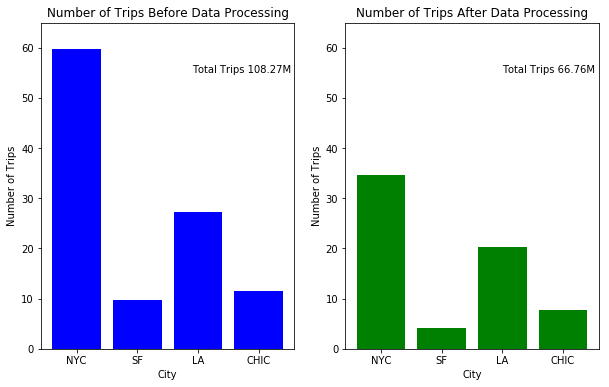

In [51]:
#plot change in counts
initial_counts = [59.7,9.71,27.32,11.54]
cleaned_counts = [34.71,4.07,20.34,7.64]
city_list = ['NYC','SF','LA','CHIC']

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)

ax1.bar(x=city_list,height=initial_counts,color='blue')
ax1.set_ylabel('Number of Trips')
ax1.set_xlabel('City')
ax1.set_ylim(top=65)
ax1.set_title("Number of Trips Before Data Processing")
ax1.text(x=1.9,y=55,s="Total Trips {}M".format(round(sum(initial_counts),2)))

ax2 = fig.add_subplot(122)

ax2.bar(x=city_list,height=cleaned_counts,color='green')
ax2.set_ylabel('Number of Trips')
ax2.set_xlabel('City')
ax2.set_ylim(top=65)
ax2.set_title("Number of Trips After Data Processing")
ax2.text(x=2,y=55,s='Total Trips {}M'.format(round(sum(cleaned_counts),2)))

In [55]:
#lists for rough calculations
commute_times = [34.6,40.8,32.8,30.9]
pop = [8398000,883000,3990000,2705000]
cleaned_counts = [34710000,4070000,20340000,7640000]

In [58]:
#print trips per person for each city
for i in range(4):
    print(city_list[i],cleaned_counts[i] / pop[i])

NYC 4.13312693498452
SF 4.609286523216308
LA 5.097744360902255
CHIC 2.824399260628466


### Time Period Analysis

In [8]:
df_list = [nyc_clean,la_clean,sf_clean,chic_clean]
time_counts = []
for i in df_list:
    df = pd.DataFrame(i.groupby('time_period2')['od_counts'].sum())
    df.reset_index(inplace=True)
    time_counts.append(df)

nyc_time = time_counts[0]
la_time = time_counts[1]
sf_time = time_counts[2]
chic_time = time_counts[3]

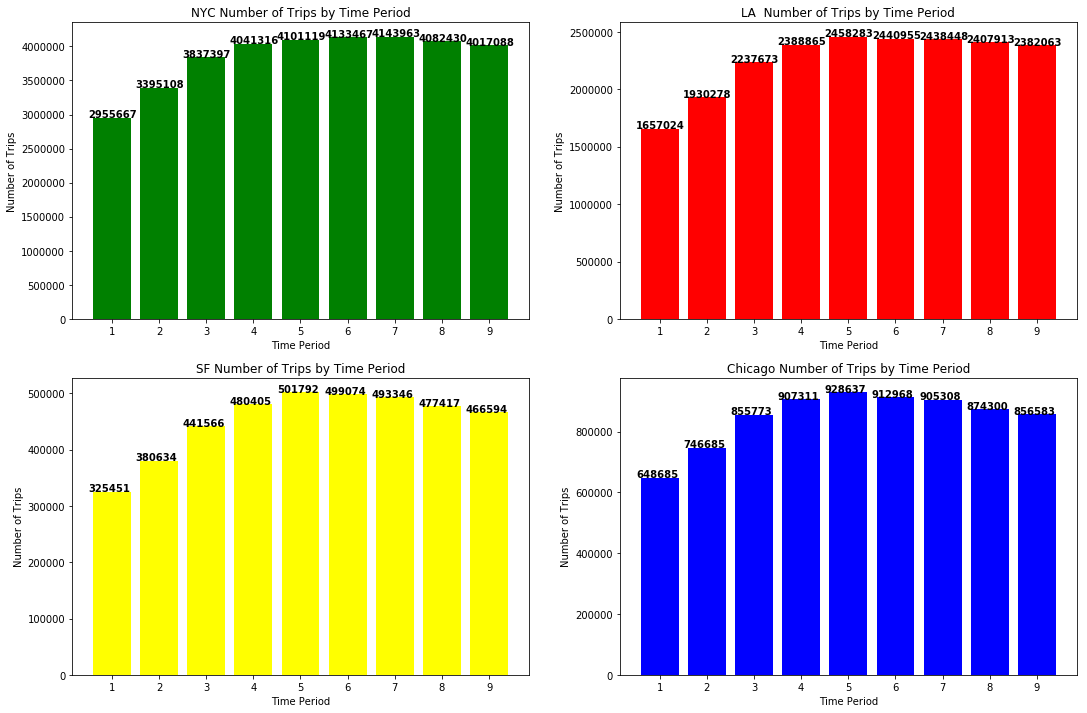

In [9]:
#create figures
fig = plt.figure(figsize=(18,12))

ax1 = fig.add_subplot(221)
ax1.bar(x=nyc_time['time_period2'],height=nyc_time['od_counts'],color='green')
ax1.set_xlabel("Time Period")
ax1.set_ylabel("Number of Trips")
ax1.set_title("NYC Number of Trips by Time Period")
ax1.set_xticks([1,2,3,4,5,6,7,8,9])
ax1.set_xticklabels([1,2,3,4,5,6,7,8,9])

for i, v in enumerate(list(nyc_time['od_counts'])):
    ax1.text(i+0.5,v + 4, str(v), fontweight='bold')

ax2 = fig.add_subplot(222)
ax2.bar(x=la_time['time_period2'],height=la_time['od_counts'],color='red')
ax2.set_xlabel("Time Period")
ax2.set_ylabel("Number of Trips")
ax2.set_title("LA  Number of Trips by Time Period")
ax2.set_xticks([1,2,3,4,5,6,7,8,9])
ax2.set_xticklabels([1,2,3,4,5,6,7,8,9])

for i, v in enumerate(list(la_time['od_counts'])):
    ax2.text(i+0.5,v + 4, str(v), fontweight='bold')

ax3 = fig.add_subplot(223)
ax3.bar(x=sf_time['time_period2'],height=sf_time['od_counts'],color='yellow')
ax3.set_xlabel("Time Period")
ax3.set_ylabel("Number of Trips")
ax3.set_title("SF Number of Trips by Time Period")
ax3.set_xticks([1,2,3,4,5,6,7,8,9])
ax3.set_xticklabels([1,2,3,4,5,6,7,8,9])

for i, v in enumerate(list(sf_time['od_counts'])):
    ax3.text(i+0.5,v+4, str(v), fontweight='bold')

ax4 = fig.add_subplot(224)
ax4.bar(x=chic_time['time_period2'],height=chic_time['od_counts'],color='blue')
ax4.set_xlabel("Time Period")
ax4.set_ylabel("Number of Trips")
ax4.set_title("Chicago Number of Trips by Time Period")
ax4.set_xticks([1,2,3,4,5,6,7,8,9])
ax4.set_xticklabels([1,2,3,4,5,6,7,8,9])

for i, v in enumerate(list(chic_time['od_counts'])):
    ax4.text(i+0.5,v + 6, str(v), fontweight='bold')

plt.show()